In [1]:
from autoencoder.autoencoder import AutoEncoder
import torch
import pickle
from autoencoder.loss import Loss
from sindy_network import SINDy
from sindy.SINDy_library import *
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
%matplotlib inline
device = 'cuda'
import numpy as np
import dill
  

In [2]:
params = pickle.load(open('utils/model1_params.pkl', 'rb'))

encoder = AutoEncoder(params, 'encoder')
decoder = AutoEncoder(params, 'decoder')
sindy = dill.load(open(f'model_lorenz_1_0', 'rb'))
sindy.to(device)
training_data = pickle.load(open('dataset_generation/test_data.pkl', 'rb'))

criterion = Loss(
        params['loss_weight_decoder'],
        params['loss_weight_sindy_z'],
        params['loss_weight_sindy_x'],
        params['loss_weight_sindy_regularization']
        )
    
def run():
    x, dx, dz, dz_pred, x_decode, dx_decode, sindy_coefficients, sindy_predict, ddz, ddx, ddx_decode, z = sindy(torch.from_numpy(training_data['x']).to(device=device), torch.from_numpy(training_data['dx']).to(device=device), torch.from_numpy(training_data['ddx']).to(device=device))
    loss = criterion(x, dx, dz, dz_pred, x_decode, dx_decode, sindy_coefficients, ddz, ddx, ddx_decode, sindy.coefficient_mask)
     
    return x, dx, dz, dz_pred, x_decode, dx_decode, sindy_coefficients, sindy_predict, ddz, ddx, ddx_decode, z, loss  

In [3]:
x, dx, dz, dz_pred, x_decode, dx_decode, sindy_coefficients, sindy_predict, ddz, ddx, ddx_decode, z, loss = run()

In [4]:
sindy_coefficients = sindy_coefficients.to('cpu')
z = z.to('cpu').detach()#.numpy()
a1 = 1
a2 = training_data['sindy_coefficients'][2,0]/sindy_coefficients[2,0]
a3 = np.sqrt(-sindy_coefficients[5,2]/sindy_coefficients[6,1]*a2**2)
b3 = -sindy_coefficients[0,2]/sindy_coefficients[3,2]

sindy_coefficients_transformed = np.zeros(sindy_coefficients.shape)
sindy_coefficients_transformed[1,0] = sindy_coefficients[1,0]
sindy_coefficients_transformed[2,0] = sindy_coefficients[2,0]*a2/a1
sindy_coefficients_transformed[1,1] = sindy_coefficients[6,1]*a1/a2*b3
sindy_coefficients_transformed[2,1] = sindy_coefficients[2,1]
sindy_coefficients_transformed[6,1] = sindy_coefficients[6,1]*a1*a3/a2
sindy_coefficients_transformed[3,2] = sindy_coefficients[3,2]
sindy_coefficients_transformed[5,2] = sindy_coefficients[5,2]*a1*a2/a3

z0_transformed = np.array([z[0,0]/a1,
                           z[0,1]/a2,
                           (z[0,2] - b3)/a3])

print(sindy_coefficients)

tensor([[-0.2067,  0.2261, -0.3259],
        [ 0.0728,  1.6787,  0.1120],
        [-0.3164,  1.5964, -0.0918],
        [-0.2406, -1.4314, -0.7607],
        [ 0.8037,  0.8298, -0.2064],
        [-0.9267,  0.5635,  0.7352],
        [ 0.1400, -1.1611,  0.2231],
        [ 0.7875, -0.8847,  0.1271],
        [-0.0388,  0.7908,  0.2429],
        [ 0.9496,  1.5199,  0.0140],
        [-0.2841,  0.0173,  1.8171],
        [ 0.0619, -0.6586,  0.5540],
        [-0.2598, -0.3193, -0.1531],
        [ 0.4314,  0.7759, -2.2955],
        [ 0.5683,  0.9684,  0.2778],
        [-0.6499, -0.8144,  1.8684],
        [-2.0405, -0.6682, -1.2592],
        [-1.4368, -1.3973, -2.8872],
        [-1.0604, -1.6022, -0.3282],
        [-1.2586,  0.2091,  0.9980]], dtype=torch.float64)


In [5]:
t = np.arange(0,20,.01)
z0 = np.array([[-8,7,27]])
lorenz_sim = sindy_simulate(training_data['z'][0, 0], t, training_data['sindy_coefficients'],
                            params['poly_order'], params['include_sine'])
z_sim = sindy_simulate(torch.Tensor.cpu(z[0]).numpy(), t, torch.Tensor.cpu(sindy.coefficient_mask).numpy()*torch.Tensor.cpu(sindy_coefficients).numpy(),
                       params['poly_order'], params['include_sine'])
z_sim_transformed = sindy_simulate(z0_transformed, t, sindy_coefficients_transformed,
                                   params['poly_order'], params['include_sine'])

KeyboardInterrupt: 

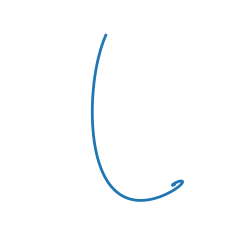

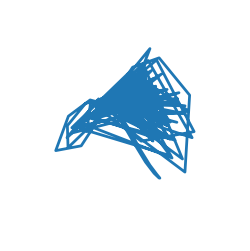

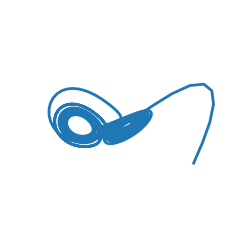

In [ ]:
fig1 = plt.figure(figsize=(3,3))
ax1 = fig1.add_subplot(111, projection='3d')
ax1.plot(z_sim[:,0], z_sim[:,1], z_sim[:,2], linewidth=2)
plt.axis('off')
ax1.view_init(azim=120)

fig2 = plt.figure(figsize=(3,3))
ax2 = fig2.add_subplot(111, projection='3d')
ax2.plot(z_sim_transformed[:,0], z_sim_transformed[:,1], z_sim_transformed[:,2], linewidth=2)
plt.axis('off')
ax2.view_init(azim=120)

fig3 = plt.figure(figsize=(3,3))
ax3 = fig3.add_subplot(111, projection='3d')
ax3.plot(lorenz_sim[:,0], lorenz_sim[:,1], lorenz_sim[:,2], linewidth=2)
plt.xticks([])
plt.axis('off')
ax3.view_init(azim=120)

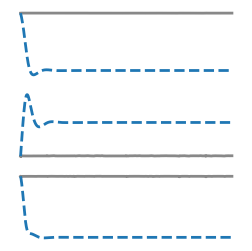

In [ ]:
plt.figure(figsize=(3,3))
for i in range(3):
    plt.subplot(3,1,i+1)
    plt.plot(t, z[:2000,i], color='#888888', linewidth=2)
    plt.plot(t, z_sim[:,i], '--', linewidth=2)
    plt.xticks([])
    plt.yticks([])
    plt.axis('off')

tensor([[-0.2067,  0.2261, -0.3259],
        [ 0.0728,  1.6787,  0.1120],
        [-0.3164,  1.5964, -0.0918],
        [-0.2406, -1.4314, -0.7607],
        [ 0.8037,  0.8298, -0.2064],
        [-0.9267,  0.5635,  0.7352],
        [ 0.1400, -1.1611,  0.2231],
        [ 0.7875, -0.8847,  0.1271],
        [-0.0388,  0.7908,  0.2429],
        [ 0.9496,  1.5199,  0.0140],
        [-0.2841,  0.0173,  1.8171],
        [ 0.0619, -0.6586,  0.5540],
        [-0.2598, -0.3193, -0.1531],
        [ 0.4314,  0.7759, -2.2955],
        [ 0.5683,  0.9684,  0.2778],
        [-0.6499, -0.8144,  1.8684],
        [-2.0405, -0.6682, -1.2592],
        [-1.4368, -1.3973, -2.8872],
        [-1.0604, -1.6022, -0.3282],
        [-1.2586,  0.2091,  0.9980]], device='cuda:0', dtype=torch.float64)


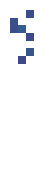

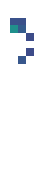

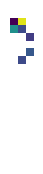

In [ ]:
Xi_plot = (params['coefficient_mask']*sindy_coefficients.numpy())
Xi_plot[Xi_plot==0] = np.inf
plt.figure(figsize=(1,2))
plt.imshow(Xi_plot, interpolation='none')
plt.xticks([])
plt.yticks([])
plt.axis('off')
plt.clim([-10,30])

Xi_transformed_plot = np.copy(sindy_coefficients_transformed)
Xi_transformed_plot[Xi_transformed_plot==0] = np.inf
plt.figure(figsize=(1,2))
plt.imshow(Xi_transformed_plot, interpolation='none')
plt.xticks([])
plt.yticks([])
plt.axis('off')
plt.clim([-10,30])

Xi_true_plot = np.copy(training_data['sindy_coefficients'])
Xi_true_plot[Xi_true_plot==0] = np.inf
Xi_true_plot[6,1] = -1.
Xi_true_plot[5,2] = 1.
plt.figure(figsize=(1,2))
plt.imshow(Xi_true_plot, interpolation='none')
plt.xticks([])
plt.yticks([])
plt.axis('off')
plt.clim([-10,30])

print(sindy.sindy_coefficients)